In [1]:
%matplotlib inline

In [2]:
import os
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /home/p22g5/AnomaliesRecycling/notebooks


In [3]:
#os.chdir('AnomaliesRecycling')
os.chdir('..')
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /home/p22g5/AnomaliesRecycling



Transfer Learning
==============================================
Based on this [tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data)


In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt

from src.transfer_learning import TransferLearningTrainer
from src.cam import CAM


plt.ion()   # interactive mode

In [5]:
torch.cuda.is_available()
torch.cuda.current_device()
torch.cuda.device_count()

1

Load Data and Data Augmentation
---------

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomVerticalFlip(p=0.5),
        #transforms.RandomRotation(degrees=(0, 180)),
        #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
        #transforms.RandomSolarize(threshold=0.5),
        #transforms.RandomAdjustSharpness(sharpness_factor=50, p=0.5),

        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
transferLearningTrainer = TransferLearningTrainer(data_transforms=data_transforms)

Visualize a few images



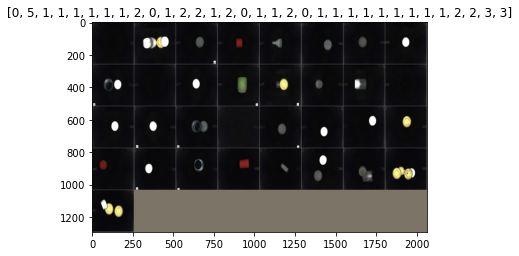

In [8]:
# Get a batch of training data
sample = next(iter(transferLearningTrainer.dataloaders['train']))
inputs, classes = sample['image'], sample['label']
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
transferLearningTrainer.imshow(out, [transferLearningTrainer.class_names[x] for x in classes])

Training the model
------------------

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [9]:
import numpy as np
import sklearn
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

y_train = transferLearningTrainer.image_datasets['train'].img_labels['count'].tolist()
class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

#weight = 1. / np.sqrt(class_sample_count) # (*20): 0.830330-1, (): 0.846847-2, (sqrt): 0.891892-4
weight = 1. - class_sample_count / sum(class_sample_count) # 0.932432-3
#weight = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train) # 0.843844-5

weight = torch.tensor(weight, dtype=torch.float).to(DEVICE)

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=1):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, input, target):
        logpt = F.log_softmax(input, dim=-1)
        logpt = torch.gather(logpt, -1, target.unsqueeze(1))

        with torch.no_grad():
            pt = torch.exp(logpt)

        loss = -1 * (1 - pt) ** self.gamma * logpt
        loss = torch.mean(self.alpha * loss)

        return loss

In [56]:
model_name = "test"
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 6, since we have 6 classes
model_ft.fc = nn.Linear(num_ftrs, len(transferLearningTrainer.class_names))
#criterion = nn.CrossEntropyLoss(weight=weight)
criterion = FocalLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

 ***Train and evaluate***

In [57]:
model_ft = transferLearningTrainer.train_model(model=model_ft,
                                               criterion=criterion,
                                               optimizer=optimizer_ft,
                                               scheduler=exp_lr_scheduler,
                                               num_epochs=10,
                                               model_name=model_name,
                                               early_stop=False)

Epoch 0/9
----------
train Loss: 0.3206 Acc: 0.7647 MAE: 0.3038 MSE: 0.5301 R^2: 0.2740
test Loss: 0.2229 Acc: 0.8348 MAE: 0.1712 MSE: 0.1832 R^2: 0.7458

Epoch 1/9
----------
train Loss: 0.1467 Acc: 0.8925 MAE: 0.1156 MSE: 0.1340 R^2: 0.8164
test Loss: 0.1678 Acc: 0.8559 MAE: 0.1471 MSE: 0.1532 R^2: 0.7875

Epoch 2/9
----------
train Loss: 0.1057 Acc: 0.9173 MAE: 0.0878 MSE: 0.0979 R^2: 0.8659
test Loss: 0.1337 Acc: 0.8799 MAE: 0.1231 MSE: 0.1291 R^2: 0.8208

Epoch 3/9
----------
train Loss: 0.0817 Acc: 0.9361 MAE: 0.0662 MSE: 0.0707 R^2: 0.9032
test Loss: 0.1230 Acc: 0.8979 MAE: 0.1051 MSE: 0.1111 R^2: 0.8458

Epoch 4/9
----------
train Loss: 0.0662 Acc: 0.9430 MAE: 0.0585 MSE: 0.0615 R^2: 0.9158
test Loss: 0.1156 Acc: 0.8769 MAE: 0.1261 MSE: 0.1321 R^2: 0.8167

Epoch 5/9
----------
train Loss: 0.0546 Acc: 0.9509 MAE: 0.0496 MSE: 0.0508 R^2: 0.9305
test Loss: 0.1084 Acc: 0.8844 MAE: 0.1186 MSE: 0.1246 R^2: 0.8271

Epoch 6/9
----------
train Loss: 0.0461 Acc: 0.9600 MAE: 0.0408 MSE: 0

In [ ]:
model_name += "_weights.pth"
model_ft = models.resnet18()
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 6, since we have 6 classes
model_ft.fc = torch.nn.Linear(num_ftrs, len(transferLearningTrainer.class_names))
model_ft.load_state_dict(torch.load(transferLearningTrainer.MODELS_DIR + model_name))
# print(model_ft)

cam = CAM(transferLearningTrainer)
cam.print_cam(model_ft)

In [ ]:
!reload_ext tensorboard
!tensorboard --logdir /cvhci/temp/p22g5/runs/

***Filenames where validation failed***

In [11]:
_ = transferLearningTrainer.print_misclassified(model_ft, plot=True)

cluttered/Anlerndaten (830).jpg
must be 2, but predicted 1
cluttered/Anlerndaten (460).jpg
must be 3, but predicted 2
harder_samples/Anlernbilder (154).jpg
must be 5, but predicted 4
harder_samples/Anlernbilder (338).jpg
must be 3, but predicted 2
cluttered/Anlerndaten (875).jpg
must be 2, but predicted 1
cluttered/Anlerndaten (161).jpg
must be 2, but predicted 1
harder_samples/Anlernbilder (171).jpg
must be 3, but predicted 2
presorted/trial (127).jpg
must be 2, but predicted 1
cluttered/Anlerndaten (764).jpg
must be 1, but predicted 0
cluttered/Anlerndaten (615).jpg
must be 2, but predicted 1
cluttered/Anlerndaten (465).jpg
must be 3, but predicted 2
harder_samples/Anlernbilder (193).jpg
must be 3, but predicted 2
harder_samples/Anlernbilder (149).jpg
must be 3, but predicted 2
presorted/trial (1326).jpg
must be 2, but predicted 1
harder_samples/Anlernbilder (362).jpg
must be 4, but predicted 2
harder_samples/Anlernbilder (88).jpg
must be 3, but predicted 2
harder_samples/Anlernbilde

In [ ]:
transferLearningTrainer.print_confusion_matrix(model_ft)

ConvNet as fixed feature extractor
----------------------------------

In [ ]:
model_name = "ResNet18_test"
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(transferLearningTrainer.class_names))
criterion = nn.CrossEntropyLoss()
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = transferLearningTrainer.train_model(model_conv,
                                                 criterion,
                                                 optimizer_conv,
                                                 exp_lr_scheduler,
                                                 num_epochs=50,
                                                 model_name=model_name)

In [ ]:
transferLearningTrainer.visualize_model(model_conv)